In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import itertools as itt
import pathlib as pl
from configparser import ConfigParser

import joblib as jl
import pandas as pd
import numpy as np
from scipy.stats import sem, wilcoxon, mannwhitneyu
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

from src.root_path import config_path, root_path
from src.visualization.palette import *
from src.visualization.interactive import plot_site_coverages

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

figfolder = root_path / 'reports' / 'figures' / 'paper'
figfolder.mkdir(parents=True, exist_ok=True)

## data loading

In [76]:
mass_cluster_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220520_minimal_DF'
if 'DF' in locals(): del(locals()['DF'])
DF = jl.load(mass_cluster_DF_file)

DF.query("source == 'real' and mult_comp_corr in ['bf_cp', 'bf_ncp']  and "
         "metric in ['integral']", inplace=True)

DF.loc[DF.analysis == 'PCA', 'PC'] = DF.loc[DF.analysis == 'PCA', 'id'].apply(lambda x: int(x.split('-')[-1]))
DF.loc[DF.metric == 'integral', 'value'] = DF.loc[DF.metric == 'integral', 'value'] / 1000

SC_DF = DF.query("analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric == 'integral'")
PCA_DF = DF.query("analysis == 'PCA' and mult_comp_corr == 'bf_cp' and metric == 'integral'").copy()
# PCA_DF['PC'] = PCA_DF.id.apply(lambda x: int(x.split('-')[-1]))

### example selection
this requires somewhat a better job, try finding some examples that show realy sparse neurons. No overlapping.

['ARM021b-02-2', 'ARM021b-04-3', 'ARM021b-05-1', 'ARM021b-05-2', 'ARM021b-06-3', ..., 'ARM021b-51-4', 'ARM021b-52-4', 'ARM021b-52-5', 'ARM021b-52-6', 'ARM021b-53-1']
Length: 33
Categories (2728, object): ['AMT020a-02-1', 'AMT020a-04-1', 'AMT020a-07-1', 'AMT020a-08-1', ..., 'ley075b-PC-6', 'ley075b-PC-7', 'ley075b-PC-8', 'ley075b-PC-9']


/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered

/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered

/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered

/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered

/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered

/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered

/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered



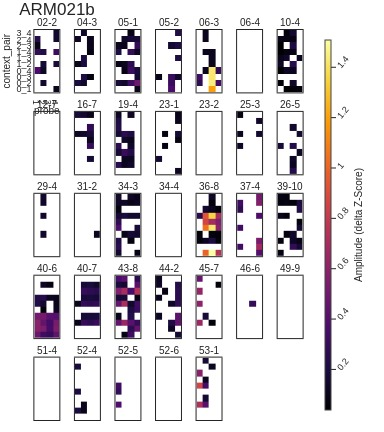

In [77]:
eg_site = 'ARM021b' # site from the example cells in figure 2
eg_site_df = SC_DF.query(f"site == '{eg_site}' and metric == 'integral' and analysis == 'SC'")
fig = plot_site_coverages(eg_site_df)
fig.update_layout(title_text= eg_site)
fig.show(renderer='jpeg', scale=1)

In [78]:
eg_neurons = ['06-3', '10-4', '36-8', '40-6', '43-8', '53-1']
eg_neurons = [f"{eg_site}-{cid}" for cid in eg_neurons]
print(eg_neurons)

['ARM021b-06-3', 'ARM021b-10-4', 'ARM021b-36-8', 'ARM021b-40-6', 'ARM021b-43-8', 'ARM021b-53-1']


# example neuron tilings
plus first pc and count of significant instances
corrected for multiple comparison of neurons

['ARM021b-06-3' 'ARM021b-10-4' 'ARM021b-36-8' 'ARM021b-40-6'
 'ARM021b-43-8' 'ARM021b-53-1' 'PC1' 'Union']


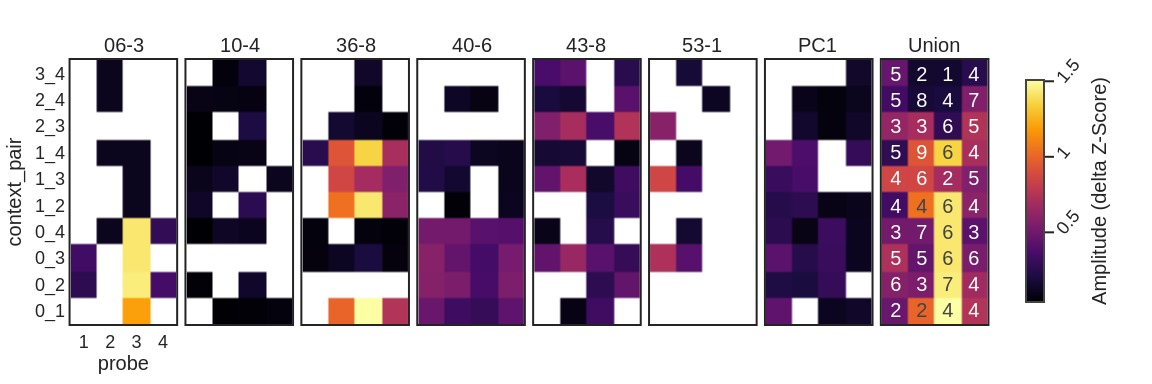

In [79]:
toplot_df = eg_site_df.query(f"id in {eg_neurons}").loc[:, ["id", "context_pair", "probe", "value"]].copy()

# first principal component
toplot_pca = PCA_DF.query(f"site == '{eg_site}' and PC == 1").copy()

# union
toplot_union = DF.query(
    f"analysis == 'SC' and mult_comp_corr == 'bf_ncp' and site == '{eg_site}' and "
    f"metric == 'integral' and value > 0"
).groupby(
    by=["context_pair", "probe"], observed=True
).agg(
    value=('value', 'max'), text=('value', 'count')
).reset_index()

# add dummy IDs to be used as subtitles
toplot_union['id'] = 'Union'
toplot_pca['id'] = 'PC1'

# hack, concatenate Union and PCA as if single units, to be handled similarly by the plotting function
toplot_df = pd.concat([toplot_df, toplot_pca, toplot_union])
fig = plot_site_coverages(toplot_df, rows=1, cols=8)

fig.update_layout(height=96*2, width=96*6)

filename = figfolder / 'fig3_eg_coverages'
# fig.write_image(filename.with_suffix('.png'), scale=2)
# fig.write_image(filename.with_suffix('.svg'))
fig.show(renderer='jpeg', scale=2)

# Summary of coverages
considering ither single cells, best, union or first  PC

In [80]:
# Creates summary DF for these different quantifications of coverage

def union_cover(df):
    df = df.pivot_table(index='id', columns=['context_pair', 'probe'], values='value', aggfunc='first', observed=True)
    arr =  df.dropna(axis=1).values > 0
    union = np.any(arr, axis=0)
    return union.sum()/union.size * 100

def best_neuron(df):
    df = df.pivot_table(index='id', columns=['context_pair', 'probe'], values='value', aggfunc='first', observed=True)
    arr =  df.dropna(axis=1).values > 0
    neu_cvr = arr.sum(axis=1) / arr.shape[1] * 100
    return neu_cvr.max()

# all single neuron coverages
by_neuron = DF.query(
    "analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric == 'integral'"
).groupby(['region', 'site', 'id'], observed=True).agg(value=('value', lambda x: np.sum(x>0)/x.size *100))

# best neuron in site
by_best =  DF.query(
    "analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric == 'integral'"
).groupby(['region', 'site'], observed=True).apply(best_neuron)
by_best.name = 'value'

# Union of single neurons, note the more strict bonferroni
by_union =  DF.query(
    "analysis == 'SC' and mult_comp_corr == 'bf_ncp' and metric == 'integral'"
).groupby(['region', 'site'], observed=True).apply(union_cover)
by_union.name = 'value'

# First PC coverage
by_PC1 = DF.query(
    "analysis == 'PCA' and PC == 1 and mult_comp_corr == 'bf_cp' and metric == 'integral'"
).groupby(['region', 'site'], observed=True).agg(value=('value', lambda x: np.sum(x>0)/x.size *100))


to_concat = {'SC':by_neuron, 'best_SC':by_best ,'union': by_union, 'PC1':by_PC1,}
toplot = list()
for name, df in to_concat.items():
    df = df.reset_index()
    df['quant'] = name
    toplot.append(df)
toplot = pd.concat(toplot)


# concatenate
to_concat = {'SC':by_neuron, 'best_SC':by_best ,'union': by_union, 'PC1':by_PC1}
toplot = list()
for name, df in to_concat.items():
    df = df.reset_index()
    df['quant'] = name
    toplot.append(df)
toplot = pd.concat(toplot)

In [81]:
# nuber or instances and sites to plot. Considere that here we are also counting neurons without any significant
# effects, therefore the number of considered neurons is greater than for figure 2 scatter plot. I have tested this,
# trust your past self MLE!
toplot.query("quant in ['SC', 'PC1']").groupby(['region', 'quant'], observed=True).agg(count=('value', 'count'))


count
region quant       
A1     PC1       36
       SC      1006
PEG    PC1       28
       SC       716

best_SC=33.54 PC1=41.44 union=53.41
SC=11.202778201423186


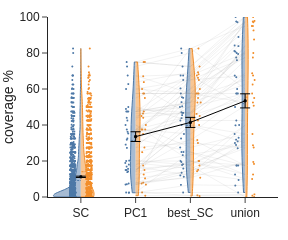

In [82]:
panelname = "coverage_summary"

fig = go.Figure()

# violins plust pointplots
for qq, quant in enumerate(['SC', 'PC1', 'best_SC', 'union']):
    fig.add_trace(go.Violin(x=toplot['quant'][(toplot['region'] == 'A1') &
                                              (toplot['quant'] == quant)],
                            y=toplot['value'][(toplot['region'] == 'A1') &
                                              (toplot['quant'] == quant)],
                            legendgroup='A1', scalegroup=f'', name='A1',
                            side='negative',
                            pointpos=-0.3,  # where to position points
                            line=dict(color=A1_COLOR,
                                      width=1),
                            showlegend=False,
                            meanline=dict(width=1,
                                          ))
                  )
    fig.add_trace(go.Violin(x=toplot['quant'][(toplot['region'] == 'PEG') &
                                              (toplot['quant'] == quant)],
                            y=toplot['value'][(toplot['region'] == 'PEG') &
                                              (toplot['quant'] == quant)],
                            legendgroup='PEG', scalegroup=f'', name='PEG',
                            side='positive',
                            pointpos=0.3,
                            line=dict(color=PEG_COLOR,
                                      width=1),
                            showlegend=False,
                            meanline=dict(width=1,
                                          ))
                  )

# update characteristics shared by all traces
fig.update_traces(meanline_visible=True,
                  marker_size=2,
                  points='all',
                  jitter=0.1,
                  scalemode='width',
                  spanmode='hard')

# add lines connecting dots for groups
linearr = toplot.query("quant in ['best_SC', 'PC1', 'union']").pivot(index='site', columns='quant', values='value'
                                                                     ).loc[:, ['PC1', 'best_SC', 'union']].values

# individual grayed out lines
x = ['PC1', 'best_SC', 'union']
for ll, line in enumerate(linearr):
    fig.add_trace(go.Scatter(x=x, y=line,
                             mode='lines',
                             opacity=0.1,
                             line=dict(
                                 color='gray',
                                 width=1)
                             ,
                             showlegend=False)
                  )

# mean values pluse error bars
mean = linearr.mean(axis=0)
print(f'best_SC={mean[0]:.2f} PC1={mean[1]:.2f} union={mean[2]:.2f}')
err = sem(linearr, axis=0)
fig.add_trace(go.Scatter(x=x, y=mean,
                         mode='markers+lines',
                         opacity=1,
                         showlegend=False,
                         marker=dict(color='black',
                                     symbol='square',
                                     size=2,
                                     line=dict(color='black',
                                               width=1)
                                     ),
                         error_y=dict(array=err,
                                      color='black',
                                      thickness=1,
                                      width=5
                                      ),
                         line=dict(color='black',
                                   width=1
                                   )
                         ))

# mean for the single cell pooled values
SC_arr = toplot.query("quant == 'SC'").value.values
mean = SC_arr.mean()
print(f'SC={mean}')
err = sem(SC_arr)

fig.add_trace(go.Scatter(x=['SC'], y=[mean],
                         mode='markers',
                         opacity=1,
                         showlegend=False,
                         marker=dict(color='black',
                                     symbol='square',
                                     size=2,
                                     line=dict(color='black',
                                               width=1)
                                     ),
                         error_y=dict(array=[err],
                                      color='black',
                                      thickness=1,
                                      width=5
                                      ),
                         ))

# test show

w, h = 3 * 96, 2.5 * 96
fig.update_layout(template="simple_white",
                  width=w, height=h,
    margin=dict(l=40, r=10, t=10, b=20),
    xaxis=dict(range=[-0.6, 3.6],
              # tickmode='array',
              #  tickvals=[0,1,2,3],
               # ticktext = ['Single Neurons', 'PC1', 'Best Neuron', 'Union'],
               title=dict(text='', standoff=0)),
    yaxis=dict(range=[0, 100],
               title=dict(text='coverage %', standoff=0)),
    violingap=0, violingroupgap=0, violinmode='overlay',
    )


filename = figfolder / 'fig3_violins'
# fig.write_image(filename.with_suffix('.png'), scale=4)
# fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=w, height=h,)
Image(img_bytes)

## stat quantification
Only relevant to quantify between adyacent columns??

In [83]:
# compare between quantifications
stats_df = list()
for q0, q1 in itt.combinations(toplot.quant.unique(), 2):
    if 'SC' in [q0, q1]:
        x = toplot.query(f"quant == '{q0}'").value.values
        y = toplot.query(f"quant == '{q1}'").value.values
        assert np.all(~np.isnan(x))
        assert np.all(~np.isnan(y))
        out = mannwhitneyu(x,y)
        stat = 'mannwhitneyu'
    else:
        ddd = toplot.query(f"quant in {[q0, q1]}").pivot(index='site', columns='quant', values='value')
        x = ddd[q0].values
        y = ddd[q1].values
        assert np.all(~np.isnan(x))
        assert np.all(~np.isnan(y))
        out = wilcoxon(x,y)
        stat = 'wilcoxon'

    d = {'pair':f'{q0}_vs_{q1}', 'stat': stat, 'pvalue': out.pvalue,
         'x_mean':np.mean(x), 'x_sem':sem(x),'y_mean':np.mean(y), 'y_sem':sem(y)}
    stats_df.append(d)

stats_df = pd.DataFrame(stats_df)
alpha = 0.01 / stats_df.shape[0]
stats_df['signif'] = stats_df['pvalue'] < alpha
stats_df

,pair,stat,pvalue,x_mean,x_sem,y_mean,y_sem,signif
0,SC_vs_best_SC,mannwhitneyu,8.130636e-25,11.202778,0.374160,41.443261,2.798979,True
1,SC_vs_union,mannwhitneyu,3.332797e-26,11.202778,0.374160,53.409617,3.919799,True
2,SC_vs_PC1,mannwhitneyu,6.701216e-19,11.202778,0.374160,33.539369,2.702664,True
3,best_SC_vs_union,wilcoxon,1.135000e-06,41.443261,2.798979,53.409617,3.919799,True
4,best_SC_vs_PC1,wilcoxon,1.494963e-05,41.443261,2.798979,33.539369,2.702664,True
5,union_vs_PC1,wilcoxon,4.203865e-09,53.409617,3.919799,33.539369,2.702664,True


In [84]:
# compare regions per quantification
stats_df = list()
for quant in toplot.quant.unique():
    if quant == 'SC':
        idx = 'id'
    else:
        idx = 'site'

    x = toplot.query(f"quant == '{quant}' and region == 'A1'").value.values
    y = toplot.query(f"quant == '{quant}' and region == 'PEG'").value.values

    assert np.all(~np.isnan(x))
    assert np.all(~np.isnan(y))
    out = mannwhitneyu(x,y)
    stat = 'mannwhitneyu'

    d = {'quant':quant, 'stat': stat, 'pvalue': out.pvalue,
         'A1mean':np.mean(x), 'PEGmean':np.mean(y)}
    stats_df.append(d)

stats_df = pd.DataFrame(stats_df)
alpha = 0.01 / stats_df.shape[0]
stats_df['signif'] = stats_df['pvalue'] < alpha
stats_df

,quant,stat,pvalue,A1mean,PEGmean,signif
0,SC,mannwhitneyu,1.108220e-07,9.179019,14.046216,True
1,best_SC,mannwhitneyu,4.772641e-01,39.841049,43.503247,False
2,union,mannwhitneyu,6.502033e-01,51.807753,55.469156,False
3,PC1,mannwhitneyu,4.363196e-01,31.438677,36.240260,False


# single cell coverage
including null dristribution

In [85]:
summary_real_vs_shuff_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220602_SC_real_shuffled'
SC_count = jl.load(summary_real_vs_shuff_DF_file)

                  mean       SEM        STD  count
source                                            
real         11.202778  0.374160  15.526516   1722
shuffled_eg   0.044372  0.007506   0.311488   1722


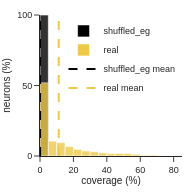

In [86]:
panelname = 'SC_coverage_not_random'

toplot = SC_count.query("metric ==  'integral' and  mult_comp_corr == 'bf_cp'").groupby(['source', 'id'],
                                                                                        observed=True).agg(
    space_cover_pct=("value", lambda x: sum(x > 0) / len(x) * 100)).reset_index()

fig = px.histogram(data_frame=toplot, x="space_cover_pct", nbins=25,
                   color='source',
                   category_orders={'source': ['shuffled_eg', 'real']},
                   color_discrete_map={'real': Yellow, 'shuffled_eg': 'black'},
                   histnorm='percent',
                   opacity=0.8,
                   barmode='overlay',
                   log_x=False)

# add mean vertical lines
means = toplot.groupby('source', observed=True).agg(mean=('space_cover_pct', np.mean),
                                                    SEM=('space_cover_pct', sem),
                                                    STD=('space_cover_pct', np.std),
                                                    count=('space_cover_pct', 'count'))
print(means)
for src, cc in zip(['shuffled_eg', 'real'], ['black', Yellow]):
    xx = means.loc[src, 'mean']
    name = f'{src} mean'
    fig.add_trace(go.Scatter(x=[xx, xx], y=[0, 100], mode='lines',
                             line=dict(dash='dash', color=cc),
                             name=name,
                             showlegend=True)
                  )

w, h = 2 * 96, 2 * 96
fig.update_layout(template="simple_white",
                  margin=dict(t=10, b=10, l=10, r=10),
                  width=w, height=h,
                  xaxis=dict(title=dict(text='coverage (%)',
                                        font_size=10,
                                        standoff=0),
                             tickfont_size=9),
                  yaxis=dict(range=(0,100),
                             constrain='domain',
                             title=dict(text='neurons (%)',
                                        font_size=10,
                                        standoff=0),
                             tickfont_size=9),
                  legend=dict(
                      title_text='',
                      font_size=9,
                      yanchor="top",
                      y=0.99,
                      xanchor="right",
                      x=0.99
                  ))

filename = figfolder / 'fig3_single_neuron_coverage'
# fig.write_image(filename.with_suffix('.png'), scale=4)
# fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=w, height=h, )
Image(img_bytes)